In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
train_df, test_df = pd.read_csv('./train_data_balanced.csv'), pd.read_csv('./test_data.csv')
X_train, X_test = train_df.drop('target', axis=1), test_df.drop('target', axis=1)
y_train, y_test = train_df['target'], test_df['target']

In [3]:
# standard
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# DNN
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 
                           tf.keras.metrics.AUC(name='auc')])
    return model

model = build_model((X_train.shape[1],))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# recall
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [6]:
# training
history = model.fit(X_train_scaled, y_train,
                   epochs=100,
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[early_stop, reduce_lr],
                   verbose=1)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6497 - auc: 0.7000 - loss: 0.6784 - val_accuracy: 0.5670 - val_auc: 0.0000e+00 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.7515 - auc: 0.8122 - loss: 0.5140 - val_accuracy: 0.5877 - val_auc: 0.0000e+00 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7676 - auc: 0.8328 - loss: 0.4831 - val_accuracy: 0.6505 - val_auc: 0.0000e+00 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.7899 - auc: 0.8508 - loss: 0.4586 - val_accuracy: 0.7097 - val_auc: 0.0000e+00 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.7891 - auc: 0.8666 - loss: 0.4381 - val_accuracy: 0.7475 - val_auc: 0.0000e+00 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - ac

In [7]:
# evaluating
print("\nEvaluating on test set:")
test_loss, test_acc, test_auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating on test set:
Test Accuracy: 0.9102
Test AUC: 0.9376


In [8]:
# evaluate
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1168
           1       0.81      0.71      0.76       291

    accuracy                           0.91      1459
   macro avg       0.87      0.84      0.85      1459
weighted avg       0.91      0.91      0.91      1459


Confusion Matrix:
[[1120   48]
 [  83  208]]

ROC AUC Score: 0.9377


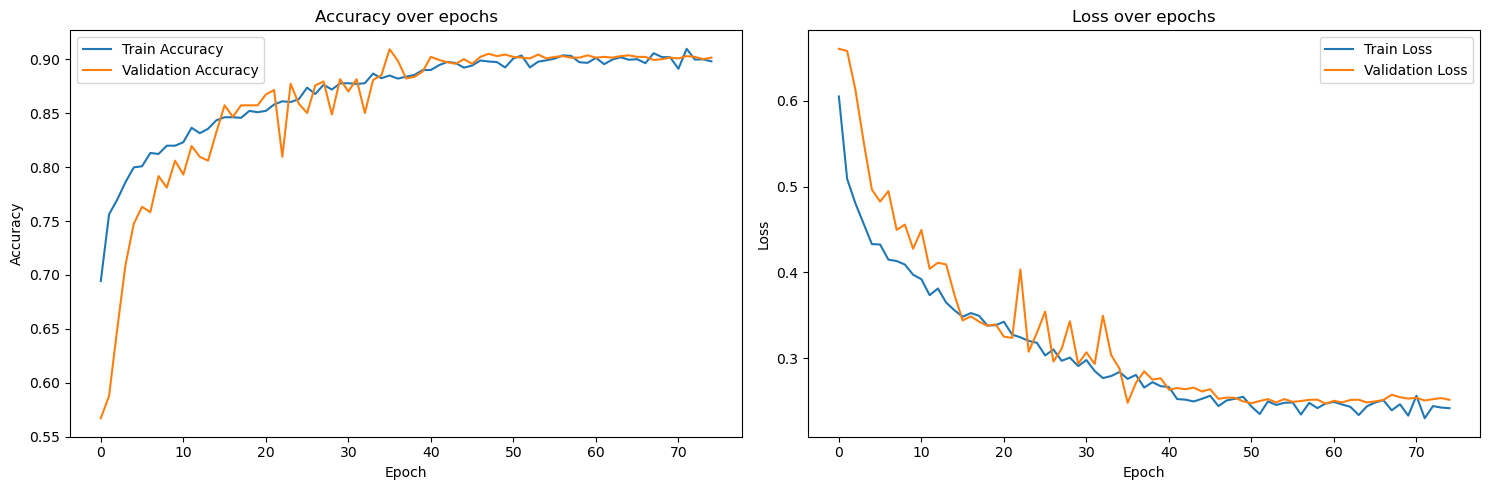

In [9]:
# training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()



plt.tight_layout()
plt.show()

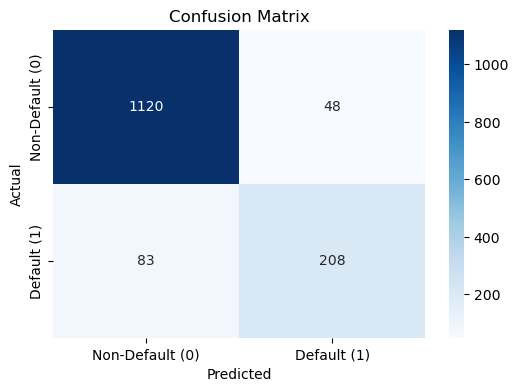

In [20]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Default (0)', 'Default (1)'], 
                yticklabels=['Non-Default (0)', 'Default (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()